# Tutorial 2.3: Analyzing Application-Layer Protocols

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Under_Construction&color=orange)


**Open notebook on:** 
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/tutorial2_anomaly_detection/tutorial2_anomaly_detection.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/tutorial2_anomaly_detection/tutorial2_anomaly_detection.ipynb)   
**Author:** Christoph R. Landolt


In this tutorial, we transition from analyzing generic network traffic (e.g., KDD Cup 99) to focusing specifically on **threats targeting web applications**.  
Web applications form the backbone of modern digital services, yet they are also among the most exposed components in a networked system. Attacks such as **SQL Injection (SQLI)**, **Cross-Site Scripting (XSS)**, and **Parameter Tampering** exploit vulnerabilities in **application-layer logic** rather than low-level network protocols.

The **CSIC 2010 Web Application Attacks Dataset** is a benchmark corpus developed by the **Spanish Research National Council (CSIC)** for evaluating **Web Application Firewalls (WAFs)** and **Intrusion Detection Systems (IDSs)** designed to protect web services.  
It provides labeled HTTP traffic directed at a simulated e-commerce web application.  
Because the dataset contains both **normal** and **malicious** HTTP requests, it is ideal for **anomaly detection** approaches that learn patterns of legitimate web behavior and flag deviations as potential attacks.


## Tutorial Objectives
By the end of this tutorial, you will be able to:
- Describe the structure and purpose of the CSIC 2010 dataset.  
- Explain key categories of web application attacks (SQLI, XSS, parameter tampering, etc.).  
- Load and preprocess HTTP request data for anomaly detection.  
- Visualize dataset distributions (normal vs. attack).  
- Prepare the dataset for model-based anomaly detection (covered in the following tutorial).


## Dataset Composition and Anomalies

The CSIC 2010 dataset consists of approximately:

- **36,000 normal** HTTP requests  
- **25,000 anomalous** HTTP requests  

All requests are synthetically generated and labeled, with attacks crafted using penetration-testing tools such as **Paros** and **W3AF**.  

### Attack Categories

| Attack Type | Description |
|--------------|-------------|
| **SQL Injection (SQLI)** | Exploiting input-validation flaws to manipulate backend SQL queries. |
| **Cross-Site Scripting (XSS)** | Injecting malicious JavaScript or HTML into web pages viewed by other users. |
| **Parameter Tampering** | Modifying GET/POST parameters or cookies to alter application logic. |
| **Buffer Overflow** | Sending oversized payloads that overflow memory buffers. |
| **Information Gathering** | Attempting to extract server or application information (e.g., file disclosure, directory traversal). |
| **CRLF Injection** | Inserting carriage-return/line-feed sequences to split HTTP responses. |
| **Unintentional Illegal Requests** | Abnormal requests violating expected application behavior without explicit malicious intent. |

These categories together provide a rich and realistic evaluation environment for modern web-security models.



## Data Structure and Features

Each record in the dataset corresponds to **one HTTP request**, parsed into multiple features representing different components of the request:

| Feature Category | Example Features | Description |
|------------------|------------------|--------------|
| **Request Metadata** | `method`, `url`, `protocol` | Basic request-line info (e.g., GET, POST, HTTP/1.1). |
| **Request Headers** | `userAgent`, `host`, `cookie`, `contentType`, `accept`, `connection` | Client and session header fields. |
| **Request Content** | `contentLength`, `payload` | Body length and content; often the attack vector. |
| **Target Label** | `label` or `classification` | Ground-truth class: *Normal* or *Anomalous*. |

The **feature-engineering challenge** lies in encoding categorical headers and extracting meaningful representations from text-heavy fields such as `url` and `payload`, which frequently contain obfuscated attack patterns.


## Structure of an HTTP Request

To analyze the CSIC 2010 dataset and detect attacks at the protocol level, it is essential to understand the basics of an HTTP request.  

An HTTP request is the message sent by a client (for example, a web browser or an application) to a server in order to request data or perform an operation. It consists of several parts, each serving a specific function.
An HTTP request has the following general structure:

<img src="./HTTP_request.png" alt="HTTP Request Structure" width="650"/>

Let’s break down the components step by step.

### Method

Originally, the HTTP protocol was designed as an interface for distributed object systems and therefore allowed a wide variety of [*method tokens*](https://www.iana.org/assignments/http-methods/http-methods.xhtml#methods). With the introduction of REST systems, the available methods were standardized in [**RFC 7231**](https://datatracker.ietf.org/doc/html/rfc7231).  

Every system **must support** at least the two methods **GET** and **HEAD**, while all other methods are **optional**.  
All standardized HTTP methods must be registered with the **IANA** (Internet Assigned Numbers Authority) [20].

In this tutorial, since the ML-IDS system is based on RESTful services, we will focus only on the following methods:

| Method | Description |
|--------|--------------|
| **GET** | Retrieves data from the server. |
| **POST** | Sends new data to the server. |
| **PUT** | Replaces an existing resource with new data. |
| **PATCH** | Partially updates an existing resource. |
| **DELETE** | Removes a resource from the server. |
| **HEAD** | Same as GET, but retrieves only the headers, not the body. |

### Request URI and Query String

The **Request URI (Uniform Resource Identifier)** specifies the resource that the client wants to access [40].  

Optionally, a **Query String** can be appended to the URI to send additional key–value pairs to the server.  
This mechanism is defined in **RFC 3986** [47].

The query string begins after a **question mark (`?`)**, and multiple key–value pairs are separated by an **ampersand (`&`)**.

**Example:**
test.php?key1=value1&key2=value2

Here:
- `test.php` → the target resource (URI)  
- `key1=value1&key2=value2` → the query string with two parameters

### HTTP Header

The **HTTP header** is a section where the client can provide metadata about itself or about the request.  
Standard header fields are defined in **RFC 2616** [40], but developers can also add custom fields.  

If the server does not support a specific header field, it simply ignores it.

Each header line follows this structure:
Key: Value
and ends with a **carriage return and line feed (CRLF)**.

**Example:**
```
Content-Type: application/json
User-Agent: Mozilla/5.0
```

#### HTTP Body

The **HTTP body** is separated from the header by an empty line (CRLF).  
It contains the **data payload** of the request—this is where the client sends information to the server (for example, form data, JSON, XML, or files).

The **format of the data** depends on the target endpoint and is specified in the header field **`Content-Type`** [40].

**Example:**
```
Content-Type: application/json
```
```json

{
"username": "alice",
"password": "1234"
}
```

## Data Loading and Integration

The dataset is typically provided as a collection of CSV files, each representing a traffic capture or session.  
The first step is to load all files into a single `pandas` DataFrame for preprocessing.


In [4]:
import os
import pandas as pd
from glob import glob
# Jupyter cell
FILE = "csic-2010-web-application-attacks.zip"
DIR = "csic-2010-web-application-attacks"
URL = "https://www.kaggle.com/api/v1/datasets/download/ispangler/csic-2010-web-application-attacks"

# Download if not exists
if not os.path.isfile(FILE):
    print(f"Downloading {FILE}...")
    !curl -L -o {FILE} {URL}
else:
    print(f"{FILE} already exists, skipping download.")

# Unzip if not exists
if not os.path.isdir(DIR):
    print(f"Unzipping {FILE}...")
    !unzip -q {FILE} -d {DIR}
else:
    print(f"{DIR} already exists, skipping unzip.")

# Load all CSV files in the dataset folder into a single DataFrame
csv_files = glob(os.path.join(DIR, "*.csv"))
dfs = [pd.read_csv(f) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

# Show the first rows
df.head()

csic-2010-web-application-attacks.zip already exists, skipping download.
csic-2010-web-application-attacks already exists, skipping unzip.


,Unnamed: 0,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


### Exploratory Analysis

Class distribution:
classification
Normal    36000
Attack    25065
Name: count, dtype: int64


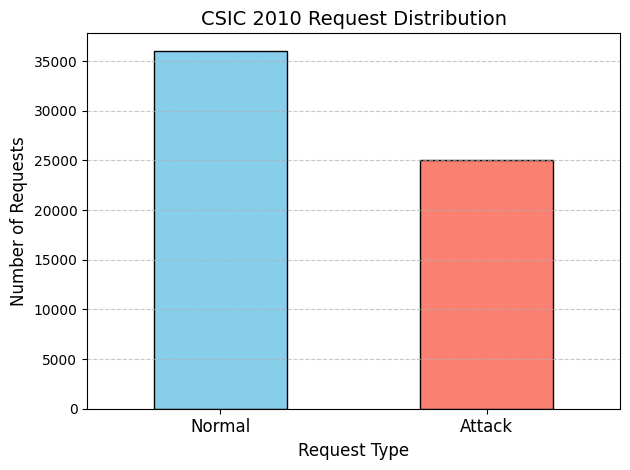

In [8]:
import matplotlib.pyplot as plt

# Map numeric labels to human-readable names
label_map = {0: "Normal", 1: "Attack"}
label_counts = df['classification'].map(label_map).value_counts()

# Print numeric summary
print("Class distribution:")
print(label_counts)

# Plot
ax = label_counts.plot(
    kind='bar',
    color=['skyblue', 'salmon'],
    edgecolor='black'
)
plt.title("CSIC 2010 Request Distribution", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.xlabel("Request Type", fontsize=12)
plt.ylabel("Number of Requests", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Conclusion


---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/clandolt/mlcysec_notebooks/)  If you found this tutorial helpful, please **⭐ star our repository** to show your support.   
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/clandolt/mlcysec_notebooks/issues)  For any **questions**, **typos**, or **bugs**, kindly open an issue on GitHub — we appreciate your feedback!

---